# Precipitation Heatmaps for Feira de Santana

This notebook loads precipitation point data, assigns them to neighborhoods, and visualizes both the aggregated precipitation by neighborhood and the individual precipitation points. It ensures correct CRS and data validation for accurate mapping.

In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Set plotting style
plt.style.use('seaborn-v0_8')

## Load and Validate Data

In [24]:
# Load precipitation data
precip_path = 'flood_features.csv'
df = pd.read_csv(precip_path)

# Check for required columns
assert 'lat' in df.columns and 'lon' in df.columns, 'lat/lon columns missing'
assert 'PRECTOTCORR' in df.columns, 'Precipitation column missing'

# Load GeoJSON with neighborhoods
gdf = gpd.read_file('../../data/raw/geospatial/feira_de_santana_convertido.geojson')

# Check CRS
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)


In [25]:
# Create geometry column and GeoDataFrame for points
points_gdf = gpd.GeoDataFrame(
    df.dropna(subset=['lat', 'lon']),
    geometry=[Point(xy) for xy in zip(df['lon'], df['lat'])],
    crs='EPSG:4326'
)

# Ensure CRS matches
if gdf.crs != points_gdf.crs:
    points_gdf = points_gdf.to_crs(gdf.crs)

# Drop points outside the city boundary
points_gdf = points_gdf[points_gdf.geometry.within(gdf.unary_union)]

C:\Users\Fernando\AppData\Local\Temp\ipykernel_19104\2758620425.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_gdf = points_gdf[points_gdf.geometry.within(gdf.unary_union)]


In [26]:
# Spatial join: assign each point to a neighborhood polygon
joined = gpd.sjoin(points_gdf, gdf, how='left', predicate='within')

# Group by neighborhood and calculate average precipitation
avg_precip = joined.groupby('NM_BAIRRO')['PRECTOTCORR'].mean().reset_index()

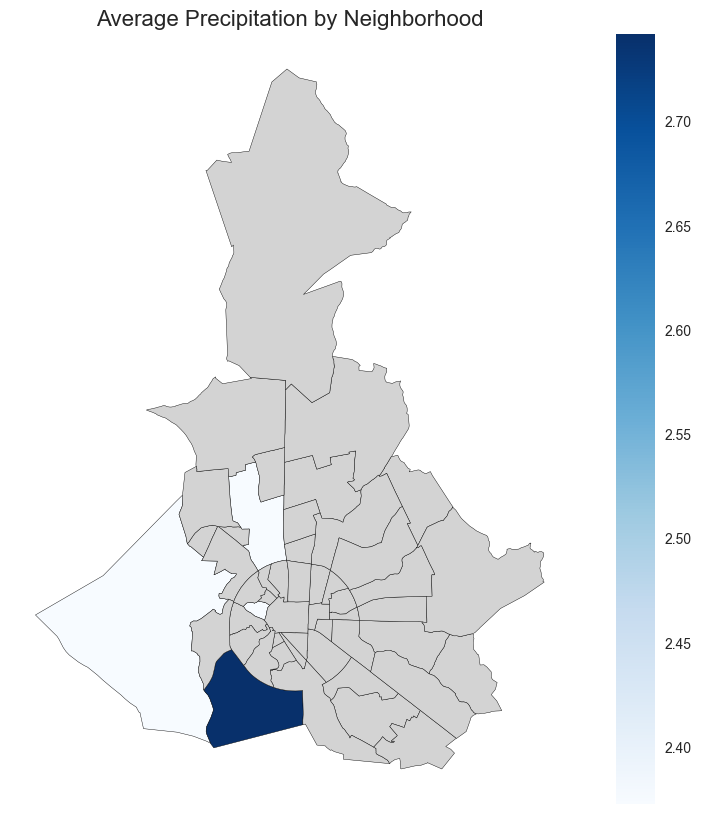

In [27]:
# Merge averages into the GeoDataFrame
gdf = gdf.merge(avg_precip, on='NM_BAIRRO', how='left')

# Plot average precipitation by neighborhood
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(column='PRECTOTCORR', ax=ax, legend=True, cmap='Blues', edgecolor='black', missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Average Precipitation by Neighborhood', fontsize=16)
ax.axis('off')
plt.show()

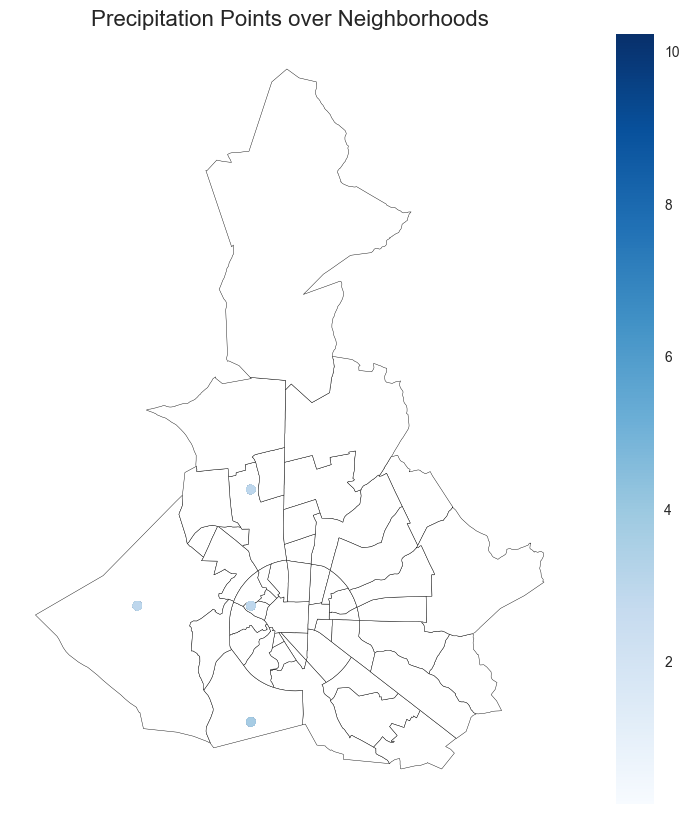

In [28]:
# Plot precipitation points over neighborhoods
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, color='white', edgecolor='black')
points = points_gdf.plot(ax=ax, column='PRECTOTCORR', cmap='Blues', legend=True, markersize=40, alpha=0.7)
ax.set_title('Precipitation Points over Neighborhoods', fontsize=16)
ax.axis('off')
plt.show()

Latitude min/max: -12.3 -12.2
Longitude min/max: -39.03 -38.98
    lat    lon
0 -12.3 -39.03
1 -12.3 -39.03
2 -12.3 -39.03
3 -12.3 -39.03
4 -12.3 -39.03


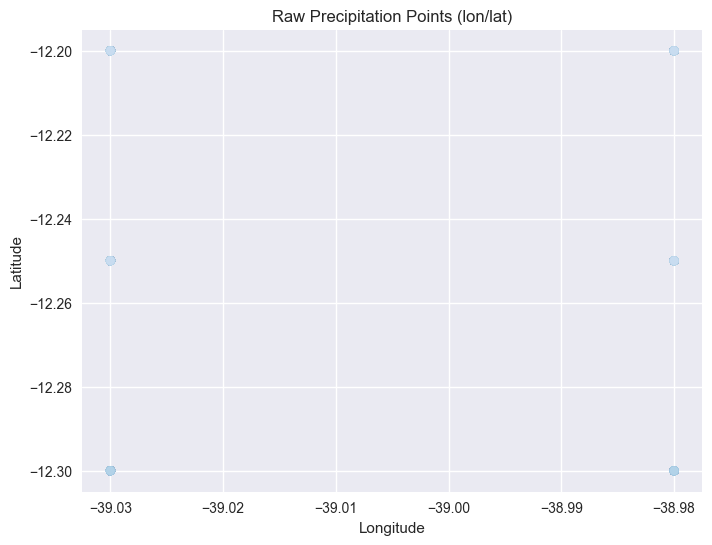

In [29]:
# Debug: Check latitude and longitude values
print('Latitude min/max:', df['lat'].min(), df['lat'].max())
print('Longitude min/max:', df['lon'].min(), df['lon'].max())
print(df[['lat', 'lon']].head())

# Plot points alone to check if they are in the expected region
plt.figure(figsize=(8, 6))
plt.scatter(df['lon'], df['lat'], c=df['PRECTOTCORR'], cmap='Blues', s=40)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Raw Precipitation Points (lon/lat)')
plt.show()

# If points are not in the expected region (Feira de Santana: lat ~ -12.2, lon ~ -38.9), check for swapped columns or wrong units.

---

### Notes & Troubleshooting
- If points do not appear in the correct locations, check that latitude and longitude columns are not swapped and are in decimal degrees.
- Ensure all data uses the same CRS (EPSG:4326 for WGS84 is standard for lat/lon).
- Points outside the city boundary are dropped for clarity.
- If you see neighborhoods with no data, check for missing or mismatched names in the join.

In [30]:
!pip install geopandas matplotlib pandas


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load Data

In [31]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load precipitation data
df = pd.read_csv("flood_features.csv")

# Load GeoJSON with neighborhoods
gdf = gpd.read_file("../../data/raw/geospatial/feira_de_santana_convertido.geojson")

## Assign Points to Neighborhoods


In [32]:
from shapely.geometry import Point

# Create geometry column in df
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
points_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=gdf.crs)

# Spatial join: assign each point to a neighborhood polygon
joined = gpd.sjoin(points_gdf, gdf, how='left', predicate='within')

## Aggregate Precipitation by Neighborhood

In [33]:
# Group by neighborhood name and calculate average precipitation
avg_precip = joined.groupby('NM_BAIRRO')['PRECTOTCORR'].mean().reset_index()

## Merge back to GeoDataFrame and Plot

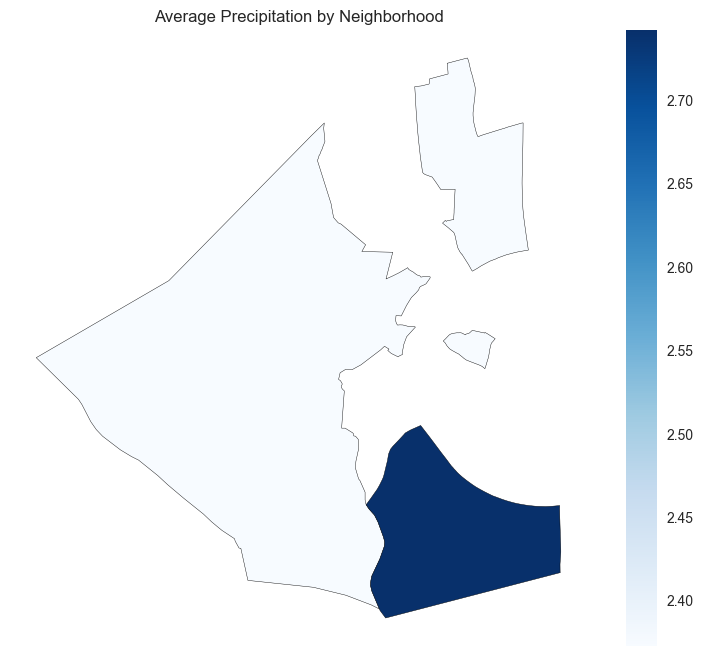

In [34]:
# Merge averages into the GeoDataFrame
gdf = gdf.merge(avg_precip, on='NM_BAIRRO', how='left')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='PRECTOTCORR', ax=ax, legend=True, cmap='Blues', edgecolor='black')
ax.set_title('Average Precipitation by Neighborhood')
plt.axis('off')
plt.show()

## Plot points

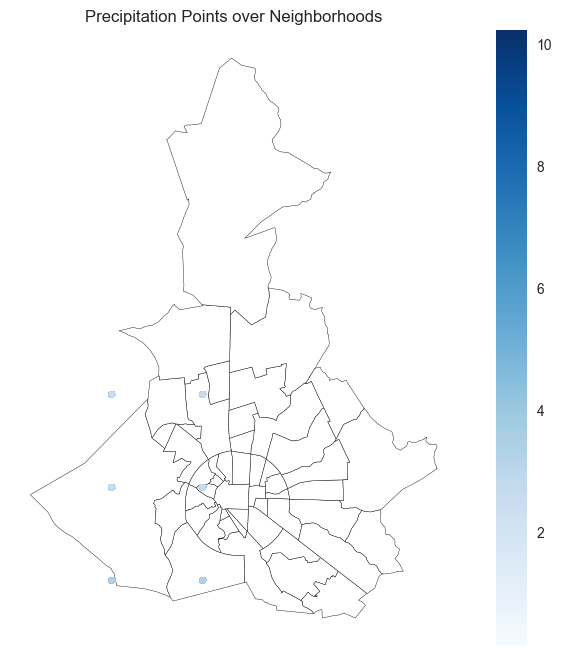

In [35]:
base = gdf.plot(color='white', edgecolor='black', figsize=(10, 8))
points_gdf.plot(ax=base, column='PRECTOTCORR', cmap='Blues', legend=True, markersize=20)
plt.title('Precipitation Points over Neighborhoods')
plt.axis('off')
plt.show()